# Fatigue Mean Correction Validation

In [1]:
import Pkg
Pkg.activate("/Users/cmichel/repos/owens")
using OWENS
using Statistics
using Random
using Plots

  Activating project at `~/repos/owens`
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.



This program is running OWENS.jl, the Offshore/Onshore Wind/Water Energy Simulator for turbine type devices

Copyright 2013-2025
National Technology & Engineering Solutions of Sandia, LLC (NTESS). 
Under the terms of Contract DE-NA0003525 with NTESS, 
the U.S. Government retains certain rights in this software.

Licensed under the LGPL GNU LESSER GENERAL PUBLIC LICENSE V3.0 License;
you may not use this file except in compliance with the License.

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.



## 1. Experimental Data
Data from 
>Figure 9.26 Axial loading S-N curves at various mean stresses for unnotched specimens of an aluminum alloy. The curves connect average fatigue strengths for a number of lots of material. (Data from [Howell 55].)

in *"Mechanical Behavior of Materials, 4th Edition" -Norman E. Dowling*

In [2]:
# Experimental Data
ncycle_log_exp = [4, 5, 6, 7, 8.7]
ncycles_exp = 10 .^ ncycle_log_exp
mean_0 = [365.7, 260.3, 190.1, 157.2, 136.3]
mean_138 = [316.2, 219.4, 155.8, 127.8, 117.2]
mean_276 = [249.7, 173.1, 123.9, 103.1, 95.6]
mean_414 = [157.3, 114.3, 84.2, 69.7, 67.7]
mean_n138 = [missing, missing, 218.0, 176.8, 157.1];

Material Properties

In [3]:
ultimate_strength = 572e6
sn_stress = mean_0*1e6
sn_log_cycles = log10.(ncycles_exp);

## 2. Stress Time-Series
Synthetic stress time series to approximate the effect of a sinusoidal stress loading. 
The rainflow count cannot handle single sinusoidal time-series so we add some noise.

In [4]:
ncyc, npercyc = 10, 10_000
time = range(0, stop=2π*ncyc, length=ncyc*npercyc)
function stress(stress_amplitude, stress_mean)
    return stress_amplitude * cos.(time) .+ stress_mean + randn(length(time)) * stress_amplitude * 0.01
end

stress (generic function with 1 method)

### 2.1 Example
Example synthetic stress time-series for one of the points on the graph. 

In [5]:
stress_amplitude, stress_mean = sn_stress[2], 138e6
println("Stress amplitude: $(stress_amplitude*1e-6) MPa")
println("Mean stress: $(stress_mean*1e-6) MPa")

Stress amplitude: 260.3 MPa
Mean stress: 138.0 MPa


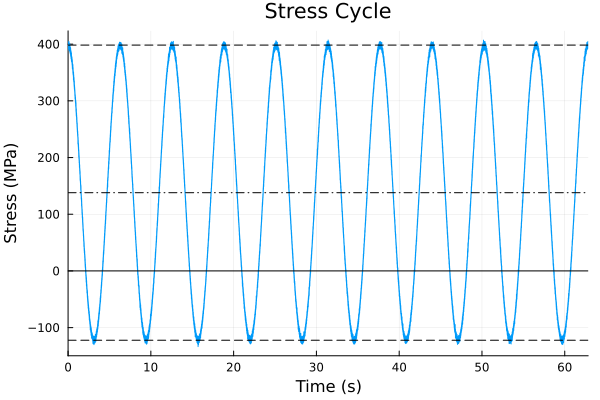

In [6]:
plot(time, stress(stress_amplitude, stress_mean) * 1e-6, label=:none, xlabel="Time (s)", ylabel="Stress (MPa)", title="Stress Cycle", grid=true, xlims=[time[begin],time[end]])
hline!([0,], c=:black, label=:none)
hline!([stress_mean]*1e-6, c=:black, label=:none, linestyle=:dashdot)
hline!([stress_mean + stress_amplitude, stress_mean - stress_amplitude] * 1e-6, c=:black, label=:none, linestyle=:dash)

## 3. OWENS
Calculating the effective S-N curve and total damage accounting for Goodman mean correction using OWENS.

### 3.1 Effective S-N Curves
#### 3.1.1 Example
We'll walk step-by-step for one case (same example as above). Note that this is merely a numerical trick to obtain the effective S-N curve when dealing with sinusoidal loading. We're doing this to compare with the experimental data as verification. A more realistic and straightforward use of OWENS to calculate the damage from an arbitrary stress signal is presented in Section 3.2.

First, we compute the rainflow count accounting for mean correction. 

In [7]:
nbins_amplitude, nbins_mean = 21, 3
mean_levels, amplitude_levels, ncycles, amplitude_levels_effective = OWENS.rainflow_mean_corrected(stress(stress_amplitude, stress_mean), ultimate_strength; nbins_amplitude, nbins_mean);

The mean level at the center position corresponds to our desired mean level.

In [8]:
mean_bins_mid = ceil(Int, nbins_mean/2)
display(mean_levels * 1e-6)
println("Real mean stress: $(stress_mean*1e-6) MPa")
println("Center bin mean stress: $(mean_levels[mean_bins_mid]*1e-6) MPa")

3-element Vector{Float64}:
 -37.949609796406335
 138.46928362560303
 314.8881770476124

Real mean stress: 138.0 MPa
Center bin mean stress: 138.46928362560303 MPa


The stress amplitude level at the final position corresponds to our desired mean level.

In [9]:
display(amplitude_levels * 1e-6)
println("Real stress amplitude: $(stress_amplitude*1e-6) MPa")
println("Center bin stress amplitude: $(amplitude_levels[end]*1e-6) MPa")

21-element Vector{Float64}:
   6.416752084091574
  19.250256252278767
  32.08376042046461
  44.91726458865045
  57.750768756836294
  70.58427292502212
  83.41777709320796
  96.25128126139381
 109.08478542957967
 121.9182895977655
   ⋮
 160.41880210232304
 173.25230627050888
 186.0858104386947
 198.9193146068806
 211.75281877506643
 224.58632294325224
 237.4198271114381
 250.25333127962392
 263.0868354478111

Real stress amplitude: 260.3 MPa
Center bin stress amplitude: 263.0868354478111 MPa


We can verify that the count at the corresponding bin is 10. 

In [10]:
display(ncycles)
println("Cycles at desired bin: $(ncycles[end, mean_bins_mid])")

21×3 Matrix{Float64}:
 13011.0  7346.0  12897.5
     0.0     0.0      0.0
     0.0     0.0      0.0
     0.0     0.0      0.0
     0.0     0.0      0.0
     0.0     0.0      0.0
     0.0     0.0      0.0
     0.0     0.0      0.0
     0.0     0.0      0.0
     0.0     0.0      0.0
     ⋮            
     0.0     0.0      0.0
     0.0     0.0      0.0
     0.0     0.0      0.0
     0.0     0.0      0.0
     0.0     0.0      0.0
     0.0     0.0      0.0
     0.0     0.0      0.0
     0.0     0.0      0.0
     0.0    10.0      0.0

Cycles at desired bin: 10.0


The effective amplitude is higher than the real amplitude due to the effect of the non-zero mean. 

In [11]:
# display(amplitude_levels_effective * 1e-6)
println("Real stress amplitude: $(stress_amplitude*1e-6) MPa")
println("Effective stress amplitude: $(amplitude_levels_effective[end, mean_bins_mid]*1e-6) MPa")

Real stress amplitude: 260.3 MPa
Effective stress amplitude: 347.1165114542624 MPa


We now use the effective amplitude to calculate the number of cycles to failure for this amplitude and mean. 

In [12]:
log_ncycles_fail = OWENS.sn_curve_mean_corrected(sn_stress, sn_log_cycles, amplitude_levels_effective)

21×3 reshape(::Vector{Union{Nothing, Float64}}, 21, 3) with eltype Union{Nothing, Float64}:
  nothing   nothing   nothing
  nothing   nothing   nothing
  nothing   nothing   nothing
  nothing   nothing   nothing
  nothing   nothing   nothing
  nothing   nothing  7.00733
  nothing   nothing  6.08113
  nothing   nothing  5.62345
  nothing  7.93295   5.21007
  nothing  6.848     4.88434
 ⋮                   
 7.39263   5.6618    4.06529
 6.78365   5.40586    nothing
 6.36251   5.17328    nothing
 6.06212   4.97722    nothing
 5.86688   4.79833    nothing
 5.67803   4.6221     nothing
 5.49369   4.45193    nothing
 5.31875   4.29124    nothing
 5.15808   4.1434     nothing

The effective S-N point is then:

In [13]:
println("Point on effective S-N curve for mean=$(stress_mean*1e-6) MPa")
println("    N-cycles to failure: 10^$(log_ncycles_fail[end, mean_bins_mid])")
println("    Stress amplitude: $(stress_amplitude*1e-6) MPa")

Point on effective S-N curve for mean=138.0 MPa
    N-cycles to failure: 10^4.1434018131783095
    Stress amplitude: 260.3 MPa


#### 3.1.2 Effective S-N Curves
The experimental S-N curve has a limited range, and because of the interpolation required (interpolation based on stress amplitude), we can only perform the verification for a few points. 

In [14]:
stress_mean = 138e6
stress_amplitudes_138 = sn_stress[1:4]
logN_138 = zeros(0)
for stress_amplitude in stress_amplitudes_138
    mean_levels, amplitude_levels, ncycles, amplitude_levels_effective = OWENS.rainflow_mean_corrected(stress(stress_amplitude, stress_mean), ultimate_strength; nbins_amplitude, nbins_mean);
    log_ncycles_fail = OWENS.sn_curve_mean_corrected(sn_stress, sn_log_cycles, amplitude_levels_effective)
    append!(logN_138, log_ncycles_fail[end, mean_bins_mid])
end

In [15]:
stress_mean = -138e6
stress_amplitudes_n138 = sn_stress[3:5]
logN_n138 = zeros(0)
for stress_amplitude in stress_amplitudes_n138
    mean_levels, amplitude_levels, ncycles, amplitude_levels_effective = OWENS.rainflow_mean_corrected(stress(stress_amplitude, stress_mean), ultimate_strength; nbins_amplitude, nbins_mean)
    log_ncycles_fail = OWENS.sn_curve_mean_corrected(sn_stress, sn_log_cycles, amplitude_levels_effective)
    append!(logN_n138, log_ncycles_fail[end, mean_bins_mid])
end

In [16]:
stress_mean = 276e6
stress_amplitudes_276 = sn_stress[1:2]
logN_276 = zeros(0)
for stress_amplitude in stress_amplitudes_276
    mean_levels, amplitude_levels, ncycles, amplitude_levels_effective = OWENS.rainflow_mean_corrected(stress(stress_amplitude, stress_mean), ultimate_strength; nbins_amplitude, nbins_mean)
    log_ncycles_fail = OWENS.sn_curve_mean_corrected(sn_stress, sn_log_cycles, amplitude_levels_effective)
    append!(logN_276, log_ncycles_fail[end, mean_bins_mid])
end

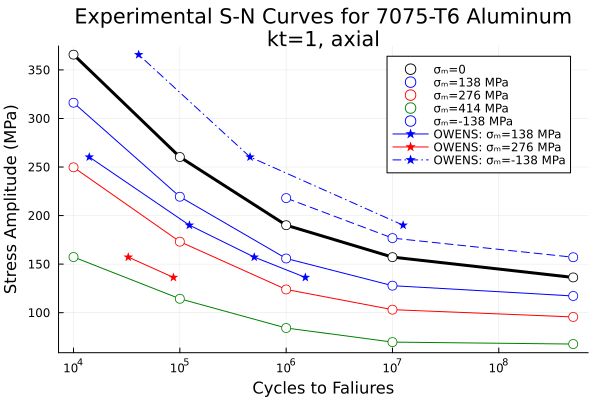

In [17]:
# Plot
color_0 = :black
color_138, color_276, color_414 = :blue, :red, :green
markersize, markercolor = 5, :white
# mean
plot(ncycles_exp, mean_0, label=:none, color=color_0, lw=3, xaxis=:log, title="Experimental S-N Curves for 7075-T6 Aluminum\nkt=1, axial", xlabel="Cycles to Faliures", ylabel="Stress Amplitude (MPa)", legend=:topright, grid=true)
scatter!(ncycles_exp, mean_0, label="σₘ=0", color=markercolor, markerstrokecolor=color_0, markersize=markersize)
# positive
for (mean, color, label) in zip([mean_138, mean_276, mean_414], [color_138, color_276, color_414], [138, 276, 414])
    plot!(ncycles_exp, mean, label=:none, color=color)
    scatter!(ncycles_exp, mean, label="σₘ=$label MPa", color=markercolor, markerstrokecolor=color, markersize=markersize)
end
#negative
for (mean, color, label) in zip([mean_n138,], [color_138,], [-138,])
    plot!(ncycles_exp, mean, label=:none, color=color, linestyle=:dash)
    scatter!(ncycles_exp, mean, label="σₘ=$label MPa", color=markercolor, markerstrokecolor=color, markersize=markersize)
end
# Miner's rule + Goodman's correction
plot!(10 .^ logN_138, stress_amplitudes_138 * 1e-6, color=color_138, markershape=:star5, markerstrokecolor=color_138, markersize=markersize, label="OWENS: σₘ=138 MPa")
plot!(10 .^ logN_276, stress_amplitudes_276 * 1e-6, color=color_276, markershape=:star5, markerstrokecolor=color_276, markersize=markersize, label="OWENS: σₘ=276 MPa")
plot!(10 .^ logN_n138, stress_amplitudes_n138 * 1e-6, color=color_138, linestyle=:dashdot, markershape=:star5, markerstrokecolor=color_138, markersize=markersize, label="OWENS: σₘ=-138 MPa")

plot!()

### 3.2 Damage
In most cases we simply want to calculate the damage (not plot effective S-N curves as above) due to an arbitrary stress timeseries. We can do this with a single function call to OWENS. The damage is calculated using Miner's rule with Goodman's mean correction. A damage of 1 or greater indicates failure. We'll use a different example since the S-N curves above do not cover a large enough range of stress amplitude for calculating damage from a random signal. 

#### 3.2.1 Stress Time Series
Let's create a random stress timeseries.

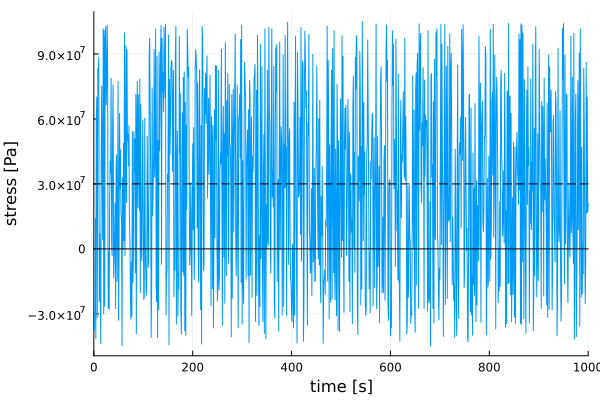

In [18]:
amplitude, mean = 150e6, 30e6
time = 1:1000
rng = Xoshiro(1) # seed for reproducibility
stress_timeseries = (rand(rng, length(time)) .- 0.5) * amplitude .+ mean

plot(time, stress_timeseries; xlabel="time [s]", ylabel="stress [Pa]", label=nothing, xlim=(0, Inf))
hline!([mean], label=nothing, color=:black, linestyle=:dash)
hline!([0], label=nothing, color=:black, linestyle=:solid)

#### 3.2.2 Material Properties

In [19]:
# Ultimate strength
ultimate_strength = 500e6

println("Ultimate strength: ", ultimate_strength, " Pa")

Ultimate strength: 5.0e8 Pa


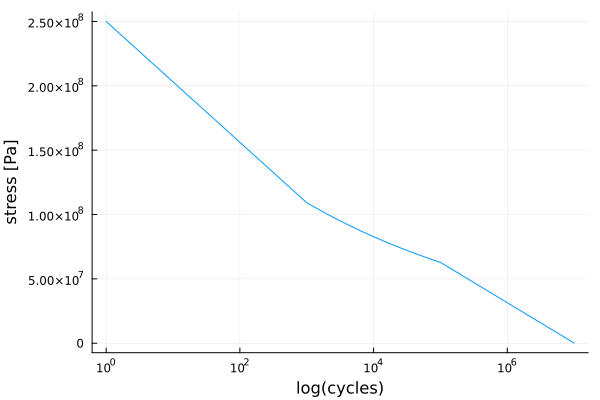

In [20]:
# S-N curve
failure_strength_coefficient = 250e6
fatigue_exponent = -0.12
ncycles = 1:1000:(1e5+1)
sn_log_cycles = log10.(ncycles)
sn_stress = failure_strength_coefficient * ncycles .^ fatigue_exponent
ncycles = vcat(ncycles, 1e7)
sn_log_cycles = vcat(sn_log_cycles, log10(1e7))
sn_stress = vcat(sn_stress, 1e5)

plot(ncycles, sn_stress; xscale=:log10, xlabel="log(cycles)", ylabel="stress [Pa]", label=nothing)

#### 3.2.3 Fatigue Damage

In [21]:
damage = OWENS.fatigue_damage(stress_timeseries, sn_stress, sn_log_cycles, ultimate_strength; nbins_amplitude=21, nbins_mean=3, mean_correction=true)
println("Damage: ", damage)

Damage: 0.002632525050465263
